Some of the codes and data in this project are from [Azure website](https://docs.microsoft.com/en-us/azure/machine-learning/service/tutorial-train-models-with-aml) and Andrew Ng's course [Deep Learning](https://www.coursera.org/specializations/deep-learning). Copyright (c) reserved. 

Licensed under the MIT License.

# Convolutional Neural Networks: Hand Sign Classification

In his project we will implement a ConvNet using TensorFlow to classify the hand sign images into 6 classes: numer 0 to number 5.

## 0 - Problem statement: SIGNS Dataset
This data is provided by Andrw Ng in his [Deep Learning course](https://www.coursera.org/specializations/deep-learning). It contains about 1000 pictures of hand signs of numbuer 0 to 5. The data format is as below:
* **Training set**: 1080 pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (180 pictures per number).
* **Test set**: 120 pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (20 pictures per number).

Note that this is a subset of the SIGNS dataset. The complete dataset contains many more signs.
Here are examples for each number, and how an explanation of how we represent the labels. These are the original pictures, before we lowered the image resolutoion to 64 by 64 pixels. 
<img src="https://i.postimg.cc/437QtzfP/SIGNS.png" style="width:800px;">

## 1 - Set up the development environment
In this step we will set up the Azure machine learning development environment.

### 1.1 Import packages
We will import Python packages we need in this session. Also display the Azure Machine Learning SDK version:

In [3]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import azureml
from azureml.core import Workspace, Run

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.0.6


### 1.2 Connect to a workspace
Create a workspace object from the existing workspace. Workspace.from_config() reads the file **config.json** and loads the details into an object named ws:

In [4]:
# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, sep = '\t')

Found the config file in: /home/nbuser/library/Model/config.json
docs-ws	westeurope	docs-aml


### 1.3 Create an experiment
Create an experiment to track the runs in your workspace. A workspace can have multiple experiments:

In [5]:
experiment_name = 'CNN-handsign'

from azureml.core import Experiment
exp = Experiment(workspace=ws, name=experiment_name)

### 1.4 Create or attach an existing AMlCompute
By using Azure Machine Learning Compute (AmlCompute), a managed service, data scientists can train machine learning models on clusters of Azure virtual machines. Examples include VMs with GPU support. In this project, we create AmlCompute as our training environment. This code creates the compute clusters for us if they don't already exist in our workspace.

Creation of the compute takes about five minutes. If the compute is already in the workspace, this code uses it and skips the creation process:

In [14]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
import os

# choose a name for your cluster
compute_name = os.environ.get("AML_COMPUTE_CLUSTER_NAME", "cpucluster")
compute_min_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MIN_NODES", 0)
compute_max_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MAX_NODES", 4)

# This example uses CPU VM. For using GPU VM, set SKU to STANDARD_NC6
vm_size = os.environ.get("AML_COMPUTE_CLUSTER_SKU", "STANDARD_D2_V2")


if compute_name in ws.compute_targets:
    compute_target = ws.compute_targets[compute_name]
    if compute_target and type(compute_target) is AmlCompute:
        print('found compute target. just use it. ' + compute_name)
else:
    print('creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = vm_size,
                                                                min_nodes = compute_min_nodes, 
                                                                max_nodes = compute_max_nodes)

    # create the cluster
    compute_target = ComputeTarget.create(ws, compute_name, provisioning_config)

    # can poll for a minimum number of nodes and for a specific timeout. 
    # if no min node count is provided it will use the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

     # For a more detailed view of current AmlCompute status, use the 'status' property    
    print(compute_target.status.serialize())

found compute target. just use it. cpucluster


We now have the necessary packages and compute resources to train a model in the cloud.

## 2 - Machine learning model and data preparation

We use Convolutional Neural Network (CNN) momdel as the machine learning model in this project. CNN, or ConvNet is a class of deep neural networks, most commonly applied to analyzing visual imagery. In this session we will do some preapration work such as loading and transforming data.
### 2.1 - Data preparation

As usual, we will start by loading in the packages. The package cnn_utils contains the functions such as load data and one hot conversion. The file cnn_utils.py must be included in the sample folder as this notebook.

In [46]:
import math
import numpy as np
import h5py
import scipy
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *


The next cell is to load the "SIGNS" dataset we are going to use.

In [47]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset('datasets')

The next cell will show you an example of a labelled image in the dataset. Feel free to change the value of index below and re-run to see different examples. 

y = 2


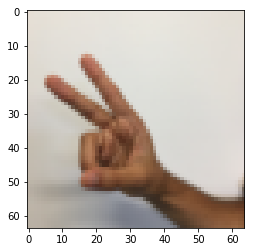

In [48]:
# Example of a picture
index = 6
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [ ]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

### 2.2 Upload data to the cloud
Now we will make the data accessible remotely by uploading that data from local machine into Azure. Then it can be accessed for remote training. The datastore is a convenient construct associated with our workspace for us to upload or download data. We can also interact with it from your remote compute targets. It's backed by an Azure Blob storage account.

The SIGNS files are uploaded into a directory named signs at the root of the datastore.

In [9]:
ds = ws.get_default_datastore()
print(ds.datastore_type, ds.account_name, ds.container_name)

ds.upload(src_dir='./datasets', target_path='signs', overwrite=True, show_progress=True)

AzureBlob docsws9812269208 azureml-blobstore-4dbb6ed5-5997-46a3-851b-0f3889b3a767
Uploading ./datasets/test_signs.h5
Uploading ./datasets/train_signs.h5
Uploaded ./datasets/test_signs.h5, 1 files out of an estimated total of 2
Uploaded ./datasets/train_signs.h5, 2 files out of an estimated total of 2


$AZUREML_DATAREFERENCE_71a64abe35634bfbb1aac639e9b23649

## 3 Train on a remote cluster
###  3.1 Create a directory
Create a directory to deliver the necessary code from local computer to the remote resource:  

In [10]:
import os
script_folder = './CNN-handsign'
os.makedirs(script_folder, exist_ok=True)

### 3.2 Create a training script
To submit the job to the cluster, first create a training script. Run the following code to create the training script called train.py in the directory we created.

In [68]:
%%writefile $script_folder/train.py   

import math
import numpy as np
import h5py
import scipy
from scipy import ndimage
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *
import argparse
import os
from azureml.core import Run
import pickle

np.random.seed(1)


# CNN model functions
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    X =  tf.placeholder("float", [None, n_H0, n_W0, n_C0])
    Y =  tf.placeholder("float", [None, n_y])
    
    return X, Y

def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 3, 8]
                        W2 : [2, 2, 8, 16]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    tf.set_random_seed(1)                             
        
    W1 = tf.get_variable("W1", [4, 4, 3, 8], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [2, 2, 8, 16], initializer = tf.contrib.layers.xavier_initializer(seed = 0))

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

    

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X, W1, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1, W2, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z3 = tf.contrib.layers.fully_connected(P2, 6, activation_fn = None)

    return Z3


def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    
    return cost



def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 300, minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    
    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer =  tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):
            
            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
                

        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
        final_param = {}
        final_param['W1'] = parameters['W1'].eval()      
        final_param['W2'] = parameters['W2'].eval()   
        return train_accuracy, test_accuracy, final_param


# let user feed in 1 parameter, the location of the data files (from datastore)
parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder mounting point')
args = parser.parse_args()

data_folder = args.data_folder + '/signs'
print('Data folder:', data_folder)


# load train and test set into numpy arrays
# note we scale the pixel intensity values to 0-1 (by dividing it with 255.0) so the model can converge faster.
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset(data_folder)
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

# get hold of the current run
run = Run.get_context()
    
# Train the model   
train_accuracy, test_accuracy, final_param = model(X_train, Y_train, X_test, Y_test)

# Result logging
run.log('train_accuracy', np.float(train_accuracy))
run.log('test_accuracy', np.float(test_accuracy))

os.makedirs('outputs', exist_ok=True)
# note file saved in the outputs folder is automatically uploaded into experiment record
f = open('outputs/hand-sign-classification.pkl','wb')
pickle.dump(final_param,f)
f.close()

Overwriting ./CNN-handsign/train.py


Notice how the script gets data and saves models:
* The training script reads an argument to find the directory that contains the data. When we submit the job later, we point to the datastore for this argument: 
```
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data directory mounting point')
```
* the training script saves our model into a directory named **outputs**: 
```
f = open('outputs/hand-sign-classification.pkl','wb')
```
Anything written in this directory is automatically uploaded into our workspace. We access our model from this directory later in the tutorial. The file cnn_utils.py is referenced from the training script to load the dataset correctly. Now we copy this script into the script folder, so that it can be accessed along with the training script on the remote resource.

In [69]:
import shutil
shutil.copy('cnn_utils.py', script_folder)

'./CNN-handsign/cnn_utils.py'

### 3.3 Create an estimator
An estimator object is used to submit the run.  Create the estimator by running the following code to define:
* The name of the estimator object, `est` 
* The directory that contains your scripts. All the files in this directory are uploaded into the cluster nodes for execution.
* The compute target.  In this case you will use the AmlCompute you created
* The training script name, train.py
* Parameters required from the training script
* Python packages needed for training

In this tutorial, this target is AmlCompute. All files in the script folder are uploaded into the cluster nodes for execution. The data_folder is set to use the datastore `ds.as_mount()`.
   

In [70]:
from azureml.train.estimator import Estimator

script_params = {
    '--data-folder': ds.as_mount(),
}

est = Estimator(source_directory=script_folder,
                script_params=script_params,
                compute_target=compute_target,
                entry_script='train.py',
                conda_packages=['tensorflow','matplotlib'])

### 3.4 Submit the job to the cluster
Run the experiment by submitting the estimator object:

In [71]:
run = exp.submit(config=est)
run

Experiment,Id,Type,Status,Details Page,Docs Page
CNN-handsign,CNN-handsign_1548010870752,azureml.scriptrun,Queued,Link to Azure Portal,Link to Documentation


Because the call is asynchronous, it returns a Preparing or Running state as soon as the job is started.

### 3.5 Monitor a remote run
In total, the first run takes about 15 minutes. But for subsequent runs, as long as the script dependencies don't change, the same image is reused. So the container startup time is much faster.
What happens while we wait:

* **Image creation**: A Docker image is created that matches the Python environment specified by the estimator. The image is uploaded to the workspace. 

    This stage happens once for each Python environment because the container is cached for subsequent runs. During image creation, logs are streamed to the 
    run history. The image creation progress can be monitored by using these logs.
    

* **Scaling**: If the remote cluster requires more nodes to do the run than currently available, additional nodes are added automatically. Scaling typically takes about five minutes.


* **Running**: In this stage, the necessary scripts and files are sent to the compute target. Then datastores are mounted or copied. And then the entry_script is run. While the job is running, stdout and the ./logs directory are streamed to the run history. We can monitor the run's progress by using these logs. 


* **Post-processing**: The ./outputs directory of the run is copied over to the run history in the workspace, so we can access these results.

We can check the progress of a running job in several ways. In this project we use a Jupyter widget and a `wait_for_completion` method.

The code below is the running progress checking using Jupyter widget. Like the run submission, the widget is asynchronous and provides live updates every 10 to 15 seconds until the job finishes.

In [72]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

The code below is the running progress checking using `wait_for_completion` method. Model training and monitoring happen in the background. Wait until the model has finished training before running more code.

In [67]:
run.wait_for_completion(show_output=False) # specify True for a verbose log

{'runId': 'CNN-handsign_1548009717015',
 'target': 'cpucluster',
 'status': 'Failed',
 'startTimeUtc': '2019-01-20T18:48:45.598105Z',
 'endTimeUtc': '2019-01-20T18:55:49.442324Z',
 'properties': {'azureml.runsource': 'experiment',
  'ContentSnapshotId': '422af809-213d-4923-8be3-2c6dfb961a1a'},
 'runDefinition': {'Script': 'train.py',
  'Arguments': ['--data-folder', '$AZUREML_DATAREFERENCE_workspaceblobstore'],
  'SourceDirectoryDataStore': None,
  'Framework': 0,
  'Communicator': 0,
  'Target': 'cpucluster',
  'DataReferences': {'workspaceblobstore': {'DataStoreName': 'workspaceblobstore',
    'Mode': 'Mount',
    'PathOnDataStore': None,
    'PathOnCompute': None,
    'Overwrite': False}},
  'JobName': None,
  'AutoPrepareEnvironment': True,
  'MaxRunDurationSeconds': None,
  'NodeCount': 1,
  'Environment': {'Python': {'InterpreterPath': 'python',
    'UserManagedDependencies': False,
    'CondaDependencies': {'name': 'project_environment',
     'dependencies': ['python=3.6.2',
   

We now have a model trained on a remote cluster. Retrieve the accuracy of the model:

In [73]:
print(run.get_metrics())

{'train_accuracy': 0.7768518328666687, 'test_accuracy': 0.6583333611488342}


## 4 Register model
The last step in the training script wrote the file `outputs/hand-sign-classification.pkl` in a directory named `outputs` in the VM of the cluster where the job is run. `outputs` is a special directory in that all content in this directory is automatically uploaded to the workspace. This content appears in the run record in the experiment under the workspace. So the model file is now also available in the workspace.

We can see files associated with that run:

In [74]:
print(run.get_file_names())

['azureml-logs/60_control_log.txt', 'azureml-logs/80_driver_log.txt', 'outputs/hand-sign-classification.pkl', 'azureml-logs/azureml.log', 'azureml-logs/55_batchai_execution.txt']


Now we register the model in the workspace, so that we or other collaborators can later query, examine, and deploy this model:

In [75]:
# register model 
model = run.register_model(model_name='hand-sign-classification', model_path='outputs/hand-sign-classification.pkl')
print(model.name, model.id, model.version, sep = '\t')

hand-sign-classification	hand-sign-classification:1	1


## 5 Clean up resources
If we don't plan to use the resources we created, we can delete them, so we don't incur any charges:
1. In the Azure portal, select **Resource groups** on the far left.
<img src="https://i.postimg.cc/44QmgNzN/post-azure5.png" style="width:800px;">
2. From the list, select the resource group you created.
3. Select **Delete resource group**.
4. Enter the resource group name. Then select **Delete**.

We can also delete just the Azure Machine Learning Compute cluster. However, autoscale is turned on, and the cluster minimum is zero. So this particular resource won't incur additional compute charges when not in use:

In [ ]:
# optionally, delete the Azure Machine Learning Compute cluster
compute_target.delete()